In [4]:

from scipy.signal import find_peaks

from astropy.io import fits
from specutils import Spectrum1D
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
import requests
from io import BytesIO
import os

## Inject Laser

In [5]:
def inject_and_plot_laser(obj_id, filt, folder="/datax/scratch/emmay/galah_spectra",
                          fwhm=1.5, laser_amp_percent=10, plot=True):
    """
    Injects a Gaussian laser spike into GALAH FITS spectrum and plots it.

    Parameters:
        obj_id (str): Object ID
        filt (str): Filter (e.g. 'B', 'V', 'R', 'I')
        folder (str): Path to FITS files
        fwhm (float): FWHM of the Gaussian in pixels
        laser_amp_percent (float): Amplitude of injection as percentage of max flux
        plot (bool): Whether to show the plot

    Returns:
        wavelength (np.ndarray): Wavelength array (in Å)
        flux_injected (np.ndarray): Flux array with injected Gaussian
    """
    filename = f"{obj_id}_{filt}.fits"
    path = os.path.join(folder, filename)

    with fits.open(path) as hdul:
        header = hdul[1].header
        flux = hdul[1].data.astype(float)

    # Build wavelength axis
    crval1 = header.get('CRVAL1')
    cdelt1 = header.get('CDELT1')
    crpix1 = header.get('CRPIX1', 1)

    npix = len(flux)
    wavelength = (crval1 + (np.arange(npix) + 1 - crpix1) * cdelt1) * u.AA

    # Inject Gaussian
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    center = npix // 2
    x = np.arange(npix)
    gaussian = np.exp(-0.5 * ((x - center) / sigma) ** 2)
    gaussian *= (laser_amp_percent / 100.0) * np.nanmax(flux)

    flux_injected = flux + gaussian

    # Plot
    if plot:
        threshold_mask = gaussian > 1e-4
        plt.figure(figsize=(13, 5))
        plt.plot(wavelength, flux, color='blue', linewidth=0.6, label="Original Spectrum")
        plt.plot(wavelength[threshold_mask], flux_injected[threshold_mask], color='red', linewidth=1.0, label="Injected Region")
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Flux")
        plt.title(f"Injected Spectrum — {obj_id} ({filt}) — Amplitude = {laser_amp_percent}%")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return wavelength.value, flux_injected, flux


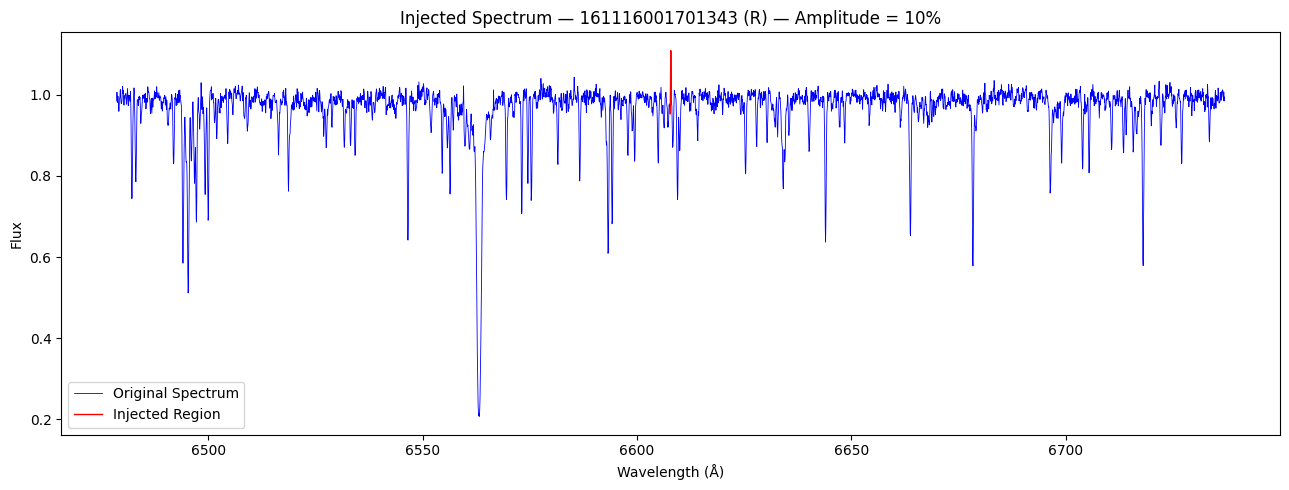

In [6]:
folder = "/datax/scratch/emmay/galah_spectra"
wavelength, flux_injected, flux_original = inject_and_plot_laser(
            obj_id=161116001701343, filt='R', folder=folder,
            laser_amp_percent=10,  # change this value as needed
            plot=True
        )

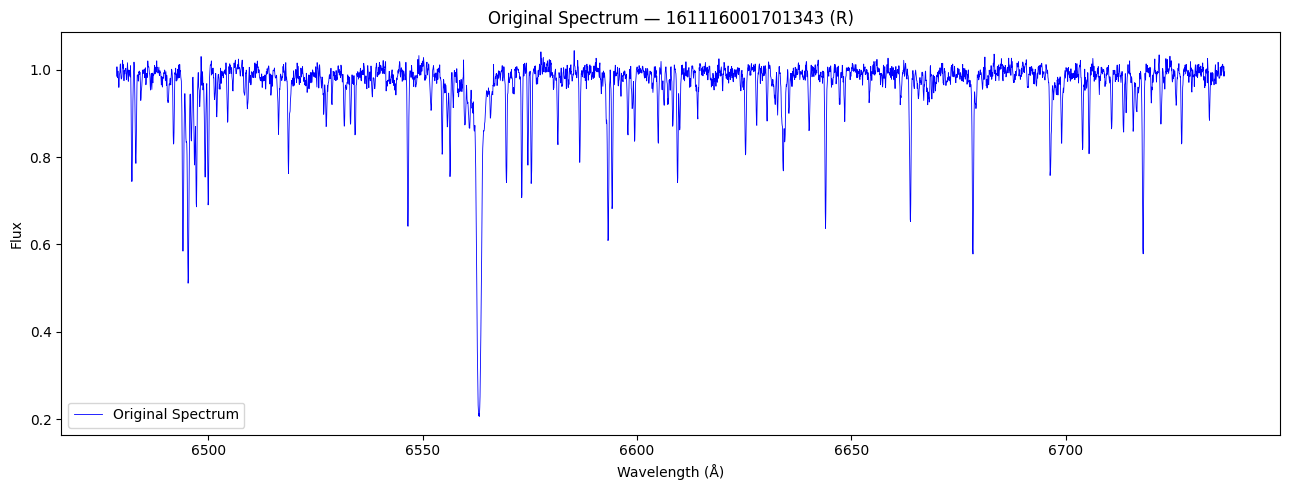

In [7]:
plt.figure(figsize=(13, 5))
plt.plot(wavelength, flux_original, color='blue', linewidth=0.6, label="Original Spectrum")
#plt.plot(wavelength[threshold_mask], flux_injected[threshold_mask], color='red', linewidth=1.0, label="Injected Region")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.title(f"Original Spectrum — 161116001701343 (R)")
plt.legend()
plt.tight_layout()
plt.show()

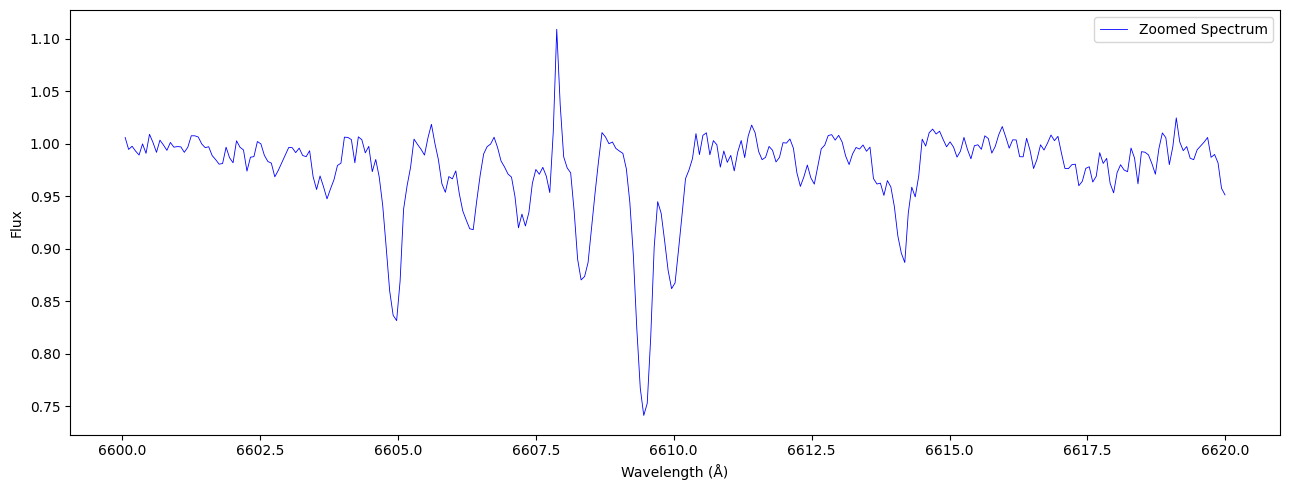

In [8]:
# Apply zoom mask for desired wavelength range
zoom_mask = (wavelength >= 6600) & (wavelength <= 6620)

# Plot zoomed region
plt.figure(figsize=(13, 5))
plt.plot(wavelength[zoom_mask], flux_injected[zoom_mask], color='blue', linewidth=0.6, label="Zoomed Spectrum")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.legend()
plt.tight_layout()
plt.show()


## Find Peak

In [19]:
def detect_laser_peak(wavelength, flux, width_range=(0.2, 10), height_fraction=0.05):
    """
    Detect a narrow injected laser peak in a spectrum.

    Parameters:
    ----------
    wavelength : array-like
        Wavelength axis (same shape as flux).
    flux : array-like
        Flux values.
    width_range : tuple
        Expected width range (in pixels) for the laser peak.
    height_fraction : float
        Fraction of max flux to use as a minimum height threshold.

    Returns:
    -------
    peak_indices : array
        Indices of detected peaks.
    peak_wavelengths : array
        Wavelengths of detected peaks.
    """

    # Set dynamic threshold: 10% of max flux by default
    height_threshold = height_fraction

    # Detect peaks
    peak_indices, properties = find_peaks(
        flux,
        threshold=height_threshold,
        #width=width_range
    )

    peak_wavelengths = wavelength[peak_indices]

    # Optional: plot
    plt.figure(figsize=(12, 5))
    plt.plot(wavelength, flux, label="Spectrum")
    plt.plot(wavelength[peak_indices], flux[peak_indices], 'rx', label="Detected Peaks")
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Flux (Counts)")
    plt.title("Laser Peak Detection")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return peak_indices, peak_wavelengths


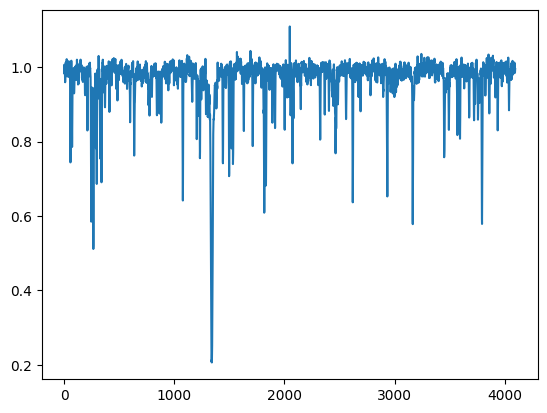

In [20]:
plt.plot(flux_injected)

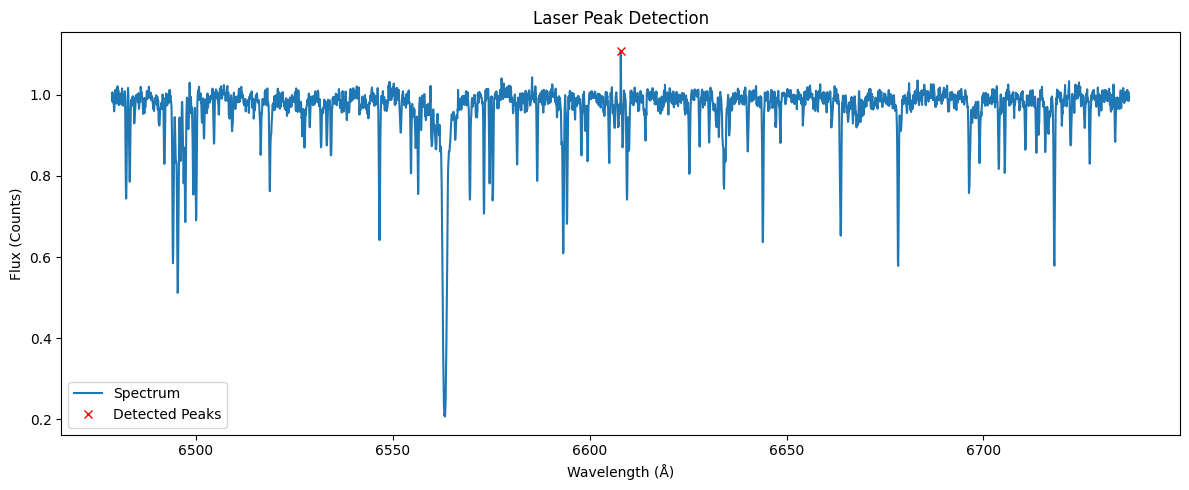

In [21]:
# Suppose you have wavelength and injected flux already from your previous code:
peak_indices, peak_wavelengths = detect_laser_peak(wavelength, flux_injected)
